# Survey Validation Data Challenge - Summer 2018

### Notebook 2 -- Tile the BGS/GAMA Fields and run survey simulations

The purpose of this notebook is to simulate DESI-like spectra of BGS targets bootstrapped from an input set of GAMA targets and redshifts, and then to run the spectra through the full DESI pipeline.

* Successful run on 18.12 up to fiber assign -- module swap fiberassign/1.0.0 required.

* Had to drop calibration exposures from explist, Cell 80. 

* Correct format for mock-targets.yaml?  E.g. list of contaminants / targets.

* As per https://github.com/desihub/survey-validation/blob/master/sv-bgs-decals/main.py, set NUMOBS_MORE=4 in .mtl prior to assignment and specified calls to 
  --nstarpetal 20
  --nskypetal 80.

* G02tilesfile missing;  Now generated by qa_gama_tiles.

In [1]:
import os, sys, time, subprocess, pdb
import glob
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

In [44]:
import fitsio
import astropy.io.fits   as fits

from   astropy.table       import Table

In [3]:
import seaborn as sns
sns.set(style='ticks', font_scale=1.6, palette='Set2')

In [4]:
%matplotlib inline

In [5]:
print("Starting at {}".format(time.asctime()))
notebook_start_time = time.time()

Starting at Fri May 10 14:02:42 2019


## Define various directories and input/output filenames.

Define and create directories under `$DESI_ROOT/datachallenge/svdc-summer2018` and set environment variables for this mapping:

| Directory             | NB variable   | Environment Variable                              |
|-----------------------|---------------|---------------------------------------------------|
| survey/               | surveydir     | \$DESISURVEY_OUTPUT                               |
| targets/              | targetdir     |                                                   |
| fiberassign/          | fibassigndir  |                                                   |
| spectro/redux/mini/   | reduxdir      | \$DESI_SPECTRO_REDUX/\$SPECPROD                   |
| spectro/sim/mini/     | simdatadir    | \$DESI_SPECTRO_DATA = \$DESI_SPECTRO_SIM/$PIXPROD |

In [6]:
if True:
    basedir = os.path.join(os.getenv('SCRATCH'), 'svdc-summer2018')
    codedir = os.path.join(os.getenv('HOME'), 'desi', 'survey-validation', 'svdc-summer2018')
    
else:
    basedir = os.path.join(os.getenv('DESI_ROOT'), 'datachallenge', 'svdc-summer2018')
    codedir = os.path.join(os.getenv('DESI_PRODUCT_ROOT'), 'survey-validation', 'svdc-summer2018')

In [7]:
print(basedir)
print(codedir)

/global/cscratch1/sd/mjwilson/svdc-summer2018
/global/homes/m/mjwilson/desi/survey-validation/svdc-summer2018


In [8]:
surveydir    = os.path.join(os.getenv('DESI_ROOT'), 'datachallenge', 'svdc-summer2018', 'survey')
targetdir    = os.path.join(basedir, 'targets')

fibassigndir = os.path.join(basedir, 'fiberassign')

os.environ['DESISURVEY_OUTPUT']  = surveydir
os.environ['DESI_SPECTRO_REDUX'] = os.path.join(basedir, 'spectro', 'redux')
os.environ['DESI_SPECTRO_SIM']   = os.path.join(basedir, 'spectro', 'sim')
os.environ['PIXPROD']            = 'bgs-gama'
os.environ['SPECPROD']           = 'bgs-gama'

reduxdir = os.path.join(os.environ['DESI_SPECTRO_REDUX'], os.environ['SPECPROD'])
simdatadir = os.path.join(os.environ['DESI_SPECTRO_SIM'], os.environ['PIXPROD'])
os.environ['DESI_SPECTRO_DATA'] = simdatadir

for dd in (surveydir, targetdir, fibassigndir, reduxdir, simdatadir):
    os.makedirs(dd, exist_ok=True)

In [9]:
samplefile       = os.path.join(basedir, 'bgs-gama-sample.fits')
tilesfile        = os.path.join(codedir, 'bgs-gama-tiles.fits')
surveyconfigfile = os.path.join(codedir, 'survey-config.yaml')
surveyrulesfile  = os.path.join(codedir, 'rules.yaml')

#### Specify the random seed for reproducibility of the survey simulations.

In [10]:
seed = 123

In [11]:
nside_mock_targets = 64

#### Specify which steps should be redone (only used if the output files already exist).

If any of the following arguments are *True* then all the associated output files and plots will be recreated.  Warning: many of these steps are time-consuming (especially the mock spectra portion of the pipeline).

In [36]:
overwrite_tiles        = False
overwrite_surveysim    = False
overwrite_mock_spectra = False
overwrite_join_spectra =  True
overwrite_fiberassign  =  True
overwrite_simspec      =  True

## Read the parent sample of GAMA targets.
This parent sample was written by the *bgs-gama-sample.ipynb* notebook.

In [13]:
def read_gama_sample():
    if os.path.isfile(samplefile):
        gama = Table(fitsio.read(samplefile, ext=1))
        print('Read {} objects from {}'.format(len(gama), samplefile))
    else:
        print('Sample file {} not found!'.format(samplefile))
        gama = []
    return gama

In [14]:
gama = read_gama_sample()
gama

Read 132487 objects from /global/cscratch1/sd/mjwilson/svdc-summer2018/bgs-gama-sample.fits


CATAID,GAMA_NAME,IC_FLAG,N_SPEC,N_GAMA_SPEC,DIST,SPECID,SURVEY,SURVEY_CODE,RA_GAMA,DEC_GAMA,WMIN,WMAX,Z,NQ,PROB,FILENAME,URL,URL_IMG,D4000N,HB_EW,HA_EW,FIELD,RELEASE,BRICKID,BRICKNAME,OBJID,TYPE,RA,DEC,RA_IVAR,DEC_IVAR,DCHISQ [5],EBV,FLUX_U,FLUX_G,FLUX_R,FLUX_I,FLUX_Z,FLUX_Y,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_U,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_I,FLUX_IVAR_Z,FLUX_IVAR_Y,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,MW_TRANSMISSION_U,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_I,MW_TRANSMISSION_Z,MW_TRANSMISSION_Y,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,NOBS_U,NOBS_G,NOBS_R,NOBS_I,NOBS_Z,NOBS_Y,NOBS_W1,NOBS_W2,NOBS_W3,NOBS_W4,RCHISQ_U,RCHISQ_G,RCHISQ_R,RCHISQ_I,RCHISQ_Z,RCHISQ_Y,RCHISQ_W1,RCHISQ_W2,RCHISQ_W3,RCHISQ_W4,FRACFLUX_U,FRACFLUX_G,FRACFLUX_R,FRACFLUX_I,FRACFLUX_Z,FRACFLUX_Y,FRACFLUX_W1,FRACFLUX_W2,FRACFLUX_W3,FRACFLUX_W4,FRACMASKED_U,FRACMASKED_G,FRACMASKED_R,FRACMASKED_I,FRACMASKED_Z,FRACMASKED_Y,FRACIN_U,FRACIN_G,FRACIN_R,FRACIN_I,FRACIN_Z,FRACIN_Y,ANYMASK_U,ANYMASK_G,ANYMASK_R,ANYMASK_I,ANYMASK_Z,ANYMASK_Y,ALLMASK_U,ALLMASK_G,ALLMASK_R,ALLMASK_I,ALLMASK_Z,ALLMASK_Y,WISEMASK_W1,WISEMASK_W2,PSFSIZE_U,PSFSIZE_G,PSFSIZE_R,PSFSIZE_I,PSFSIZE_Z,PSFSIZE_Y,PSFDEPTH_U,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_I,PSFDEPTH_Z,PSFDEPTH_Y,GALDEPTH_U,GALDEPTH_G,GALDEPTH_R,GALDEPTH_I,GALDEPTH_Z,GALDEPTH_Y,WISE_COADD_ID,FRACDEV,FRACDEV_IVAR,SHAPEDEV_R,SHAPEDEV_R_IVAR,SHAPEDEV_E1,SHAPEDEV_E1_IVAR,SHAPEDEV_E2,SHAPEDEV_E2_IVAR,SHAPEEXP_R,SHAPEEXP_R_IVAR,SHAPEEXP_E1,SHAPEEXP_E1_IVAR,SHAPEEXP_E2,SHAPEEXP_E2_IVAR,FIBERFLUX_U,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_I,FIBERFLUX_Z,FIBERFLUX_Y,FIBERTOTFLUX_U,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_I,FIBERTOTFLUX_Z,FIBERTOTFLUX_Y,REF_ID,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_RP_MEAN_MAG,GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR,GAIA_ASTROMETRIC_EXCESS_NOISE,GAIA_DUPLICATED_SOURCE,PARALLAX,PARALLAX_IVAR,PMRA,PMRA_IVAR,PMDEC,PMDEC_IVAR,BRIGHTSTARINBLOB
int32,bytes23,int16,int16,int16,float32,bytes33,bytes9,int16,float64,float64,float32,float64,float32,int16,float32,bytes67,bytes88,bytes92,float32,float32,float32,bytes9,int32,int32,bytes8,int32,bytes4,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,uint8,uint8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,bool,float32,float32,float32,float32,float32,float32,bool
6802,GAMAJ113601.43+004315.3,4104,1,1,0.07,G12_Y3_017_187,GAMA,5,174.006,0.72093,3727.71,8857.67,0.05054,4,1.0,/GAMA/dr3/data/spectra/gama/reduced_27/1d/G12_Y3_017_187.fit,http://www.gama-survey.org/dr3/data/spectra/gama/reduced_27/1d/G12_Y3_017_187.fit,http://www.gama-survey.org/dr3/data/spectra/gama/reduced_27/1d/png/G12_Y3_017_187.png,1.81131,5.20334,27.8028,G12,7000,335384,1741p007,1909,EXP,174.005987533,0.72094157246,7.40685e+12,4.4597e+12,475690.0 .. 615579.0,0.0223431,0.0,22.1154,36.5512,0.0,50.9447,0.0,35.6419,23.8391,34.8189,17.7839,0.0,385.058,266.155,0.0,27.5049,0.0,2.46397,0.472394

## Visualize the tiling of the G02, G09, G12, and G15 GAMA fields.

Here, we use a tiling solution generated by Kyle Dawson but we change the program name to DARK and set OBSCONDITIONS to zero (=DARK) until the appropriate hooks can be added to *desisurvey*.

In [15]:
def fix_tiles():
    """
    Ad hoc changes to the nominal tile file so we can get desisurvey running.
    """
    dawsonfile = os.path.join(codedir, 'bgs-gama-tiles-kdawson.fits')

    if os.path.isfile(dawsonfile):
        tiles = Table(fitsio.read(tilesfile, ext=1))
        print('Updating PROGRAM and OBSCONDITIONS in {}'.format(dawsonfile))
        tiles['PASS'] = 1
        tiles['PROGRAM'] = 'DARK'
        tiles['OBSCONDITIONS'] = 0 # dark
        print('Writing {}'.format(tilesfile))
        tiles.write(tilesfile, overwrite=True)
    
    else:
        print('Dawson tiles file {} not found!'.format(dawsonfile))

In [16]:
def plot_tile(ra, dec, r=1.606, color='k', ax=None):
    '''
    Approximate plot of tile location
    '''
    ang = np.linspace(0, 2*np.pi, 100)
    x = ra + r*np.cos(ang)/np.cos(np.radians(dec))
    y = dec + r*np.sin(ang)
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(x,y, '-', color=color, alpha=0.5)

In [17]:
def read_gama_tiles(overwrite=False):
    """
    Read the tiles file.
    """
    
    if overwrite:
        fix_tiles()
    
    if os.path.isfile(tilesfile):
        tiles = Table(fitsio.read(tilesfile, ext=1))
        print('Read {} tiles from {}'.format(len(tiles), tilesfile))
        
    else:
        print('Tiles file {} not found!'.format(tilesfile))
        tiles = []
    
    return tiles

In [41]:
def qa_gama_tiles(gama=None, tiles=None, gamafield=None, overwrite=False):
    if gama is None:
        gama  = read_gama_sample()

    if tiles is None:
        tiles = read_gama_tiles()

    fig, ax = plt.subplots(2, 2, figsize=(10, 6))
    ax      =  ax.reshape(4)
    
    for thisax, field in zip(ax, sorted(set(gama['FIELD']))):
        infield = gama['FIELD'] == field
    
        if np.count_nonzero(infield) > 0:
            thisax.scatter(gama['RA'][infield], gama['DEC'][infield], 
                           s=1, alpha=0.5, marker='s')
        
            ww = ( (tiles['RA'] > gama['RA'][infield].min()) * (tiles['RA'] < gama['RA'][infield].max()) * 
                   (tiles['DEC'] > gama['DEC'][infield].min()) * (tiles['DEC'] < gama['DEC'][infield].max()) )
            
            tiles[ww].write('bgs-gama-tiles_%s.fits' % field, overwrite=True)
            
            for tt in tiles[ww]:
                plot_tile(tt['RA'], tt['DEC'], ax=thisax)
            
        thisax.set_xlabel('RA')
        thisax.set_ylabel('Dec')
        
        thisax.invert_xaxis()
        
        thisax.set_title(field)
    
    fig.tight_layout()
    
    if overwrite:
        pngfile = os.path.join(basedir, 'qaplots', 'qa-gama-tiles.png')
        print('Writing {}'.format(pngfile))
        fig.savefig(pngfile)    

In [19]:
tiles = read_gama_tiles(overwrite=overwrite_tiles)
tiles

Read 94 tiles from /global/homes/m/mjwilson/desi/survey-validation/svdc-summer2018/bgs-gama-tiles.fits


TILEID,RA,DEC,PASS,IN_DESI,EBV_MED,AIRMASS,STAR_DENSITY,EXPOSEFAC,PROGRAM,OBSCONDITIONS
int32,float64,float64,int16,int16,float32,float32,float32,float32,bytes6,int32
100000,212.399993896,-0.819999992847,1,1,0.0504712,1.0,1.0,1.0,DARK,0
100001,213.199996948,-0.800000011921,1,1,0.0498524,1.0,1.0,1.0,DARK,0
100002,214.0,-0.77999997139,1,1,0.049985,1.0,1.0,1.0,DARK,0
100003,214.799987793,-0.759999990463,1,1,0.0459586,1.0,1.0,1.0,DARK,0
100004,215.599990845,-0.819999992847,1,1,0.0451689,1.0,1.0,1.0,DARK,0
100005,216.399993896,-0.800000011921,1,1,0.042806,1.0,1.0,1.0,DARK,0
100006,217.199996948,-0.77999997139,1,1,0.0435473,1.0,1.0,1.0,DARK,0
100007,218.0,-0.759999990463,1,1,0.042242,1.0,1.0,1.0,DARK,0
100008,218.799987793,-0.819999992847,1,1,0.042335,1.0,1.0,1.0,DARK,0


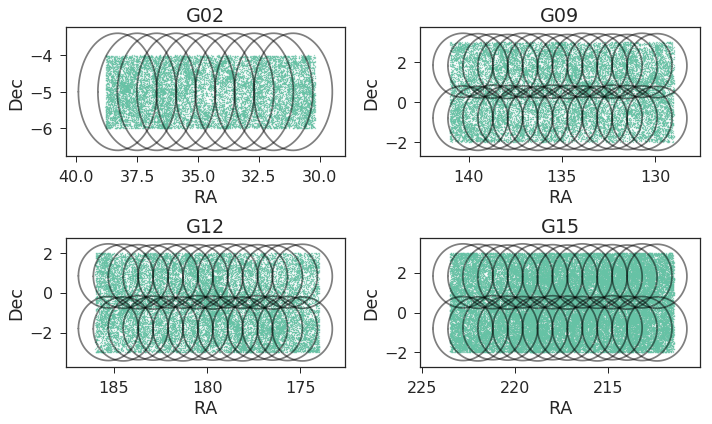

In [42]:
qa_gama_tiles(gama, tiles, overwrite=overwrite_tiles)

In [59]:
#  Write Tile IDs to .txt for fiberassign. 
np.savetxt('bgs-gama-tiles-kdawson.txt', tiles['TILEID'], fmt='%d')

## Run survey simulations (currently deprecated)

The code below enables one to simulate SV observations of the GAMA fields using *desisurvey*:  This provides exposure times etc. 
However, since the dates of SV are still uncertain (and three of the four GAMA fields are spring or late-fall fields), we have opted to simulate observing conditions by simply drawing from the full-survey simulations.

In [21]:
def survey_simulations(tiles, overwrite=False):
    """
    Run survey simulations.
    """
    expfile = os.path.join(surveydir, 'exposures.fits')
    progressfile = os.path.join(surveydir, 'progress.fits')
    
    if overwrite or not os.path.isfile(expfile):
        from desisurvey.progress import Progress
        from desisurvey.config import Configuration
        from surveysim.util import add_calibration_exposures
    
        Configuration.reset()
        config = Configuration(surveyconfigfile)

        survey_logname = os.path.join(surveydir, 'survey.log')
        print('Running survey simulations; logging to {}'.format(survey_logname)) ; print()
        
        with open(survey_logname, 'w') as logfile:
            cmd = "surveyinit --recalc --config-file {} --output-path {}".format(surveyconfigfile, surveydir)
            print(cmd) ; print()
            err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
            assert err == 0

            # Assume a zero-day fiber assignment delay..
            cmd = "surveyplan --config-file {} --rules {} --output-path {} --create --fa-delay 0d".format(
                surveyconfigfile, surveyrulesfile, surveydir)
            print(cmd) ; print()
            err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
            assert err == 0

            cmd = "surveysim --config-file {} --output-path {} --seed {}".format(
                surveyconfigfile, surveydir, seed)
            print(cmd) ; print()
            err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
            assert err == 0

            # Do we need new rules?!?
            plan_cmd = 'surveyplan --config-file {} --rules {} --output-path {} --fa-delay 0d'.format(
                surveyconfigfile, surveyrulesfile, surveydir)
            sim_cmd = 'surveysim --resume --config-file {} --output-path {} --seed {}'.format(
                surveyconfigfile, surveydir, seed)
            print(sim_cmd) ; print()
            while True:
                lastdate = open(os.path.join(surveydir, 'last_date.txt')).readline().strip()
                progress = Table.read(os.path.join(surveydir, 'progress.fits'), 1)
                ndone = np.count_nonzero(progress['status'] == 2)
                print('Starting {} with {}/{} tiles completed {}'.format(
                    lastdate, ndone, len(progress), time.asctime()))
                if subprocess.call(plan_cmd.split(), stdout=logfile, stderr=logfile) != 0:
                    break
                if subprocess.call(sim_cmd.split(), stdout=logfile, stderr=logfile) != 0:
                    break

        # Make sure observing truly finished.
        if not os.path.exists(progressfile):
            print("ERROR: Missing {}".format(progressfile))
            print("Check {} for what might have gone wrong".format(survey_logname))
    
        print('Files in {}:\n'.format(surveydir))
        !ls $surveydir
        
        # convert progress.fits -> exposures.fits
        p = Progress(restore=os.path.join(surveydir, 'progress.fits'))
        explist = p.get_exposures()
        explist = add_calibration_exposures(explist)

        # Sanity check that all tiles in the subset were observed in the exposures list.
        if not np.all(np.in1d(tiles['TILEID'], explist['TILEID'])):
            print("ERROR: some tiles weren't observed;\ncheck {} for failures".format(survey_logname) )
            print("Missing TILEIDs:", set(tiles['TILEID']) - set(explist['TILEID']))
        else:
            print('All tiles in the subset were observed at least once.')
            explist.write(expfile, overwrite=True)
            print('Writing {}'.format(expfile))                

        # Optionally make a movie
        if False:
            cmd = "surveymovie --config-file {} --output-path {}".format(
                surveyconfigfile, surveydir)
            err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
            assert err == 0
    else:
        print('Simulated observing already completed.')
        explist = Table.read(expfile)
        print('Read {} exposures from {}'.format(len(explist), expfile))

    return explist

In [22]:
def sample_survey_simulations(tiles, overwrite=False, seed=None):
    """
    Generate the exposures file by drawing from the SVDC 2018 full-survey simulations.
    """
    expfile = os.path.join(surveydir, 'exposures.fits')
    
    if overwrite or not os.path.isfile(expfile):
        from astropy.table  import vstack
        from surveysim.util import add_calibration_exposures

        rand        = np.random.RandomState(seed)
        
        simexpfile = os.path.join(os.getenv('DESI_ROOT'), 'datachallenge', 'surveysim2017', 'depth_0m', 'exposures.fits')
        #simexpfile  = os.path.join(os.getenv('DESI_ROOT'), 'datachallenge', 'svdc-summer2018', 'survey', 'exposures.fits')
        #simexpfile  = os.path.join(os.getenv('DESI_ROOT'), 'datachallenge', 'surveysim2018', 'survey', 'exposures.fits')
        
        if not os.path.isfile(simexpfile):
            print('Exposures file {} not found!'.format(simexpfile))
            raise IOError

        exp = Table.read(simexpfile)

        print('Read {} parent exposures from {}'.format(len(exp), simexpfile))

        # flag CR splits.  CR split? 
        _, uniq = np.unique(exp['TILEID'].data, return_index=True)
        
        explist = []
        
        ##  Range of EBV for tiles:  0.0504712 0.0192004    
        for tt in tiles:
            # Find exposures with the correct PROGRAM and close in Galactic 
            # reddening and then choose one at random (with uniform probability).
            # If there is more than one exposure, take both (CR split).            
            ww = np.where( (exp['PROGRAM'][uniq] == tt['PROGRAM']) * 
                           (np.abs(exp['EBMV'][uniq]-tt['EBV_MED']) < 0.02) )[0]
            
            if np.count_nonzero(ww) == 0:
                ww = np.where( (exp['PROGRAM'][uniq] == tt['PROGRAM']) * 
                               (np.abs(exp['EBMV'][uniq]-tt['EBV_MED']) < 0.051) )[0]
                
                if np.count_nonzero(ww) == 0:
                    print('Insufficient comparable exposures!')
                    raise ValueError
                
            # choose one at random.
            this = rand.choice(ww)
            
            # bring back CR splits.
            these = exp['TILEID'] == exp['TILEID'][uniq][this]
            
            _explist = vstack(exp[these])
            
            # Replace exposure data with criteria for Kyle's tiles.
            _explist['TILEID'] = tt['TILEID']
            _explist['PASS']   = tt['PASS']
            _explist['EBMV']   = tt['EBV_MED']
            _explist['RA']     = tt['RA']
            _explist['DEC']    = tt['DEC']
            explist.append(_explist)

        explist = vstack(explist)
        
        # Assign all 94 tiles to a single (wonderful) NIGHT and MJD.
        this                   = np.where(exp['NIGHT'].data == '20191201')[0][0]
        explist['NIGHT'][:]    = exp['NIGHT'][this]
        explist['MJD'][:]      = exp['MJD'][this]
        
        # Add monotonically increasing epsilon perturbation to MJD to beat diff(MJD) > 0 catch in surveysim/util.py  
        epsilons               = 1.e-1 * np.sort(np.random.uniform(0., 1., len(explist['MJD'])))
        explist['MJD']        += epsilons

        #explist               = add_calibration_exposures(explist)

        # sequential IDs
        explist['EXPID']       = np.arange(len(explist))

    else:
        print('Simulated observing already completed.')
        explist = Table.read(expfile)
        print('Read {} exposures from {}'.format(len(explist), expfile))

    return explist

In [23]:
#%time explist = survey_simulations(tiles, overwrite=overwrite_surveysim)
%time explist = sample_survey_simulations(tiles, overwrite=overwrite_surveysim, seed=seed)
explist

Simulated observing already completed.
Read 11 exposures from /global/project/projectdirs/desi/datachallenge/svdc-summer2018/survey/exposures.fits
CPU times: user 19.5 ms, sys: 3.88 ms, total: 23.4 ms
Wall time: 22.4 ms


EXPID,TILEID,PASS,RA,DEC,EBMV,NIGHT,MJD,EXPTIME,SEEING,TRANSPARENCY,AIRMASS,MOONFRAC,MOONALT,MOONSEP,PROGRAM,FLAVOR
,,,deg,deg,,,,s,arcsec,,,,deg,deg,,
int32,int32,int16,float64,float64,float32,str8,float64,float64,float64,float64,float64,float64,float64,float64,str6,str7
0,-1,-1,0.0,0.0,0.0,20190904,58731.2959023,10.0,0.0,0.0,0.0,0.0,0.0,0.0,CALIB,arc
1,-1,-1,0.0,0.0,0.0,20190904,58731.2963652,10.0,0.0,0.0,0.0,0.0,0.0,0.0,CALIB,arc
2,-1,-1,0.0,0.0,0.0,20190904,58731.2968282,10.0,0.0,0.0,0.0,0.0,0.0,0.0,CALIB,arc
3,-1,-1,0.0,0.0,0.0,20190904,58731.2972912,10.0,0.0,0.0,0.0,0.0,0.0,0.0,CALIB,flat
4,-1,-1,0.0,0.0,0.0,20190904,58731.2977541,10.0,0.0,0.0,0.0,0.0,0.0,0.0,CALIB,flat
5,-1,-1,0.0,0.0,0.0,20190904,58731.2982171,10.0,0.0,0.0,0.0,0.0,0.0,0.0,CALIB,flat
6,100000,1,29.4,-5.0,0.0,20190904,58731.2986801,775.497549491,1.25194072723,0.946120202541,1.99576010098,0.413693953065,-17.1389692893,142.239179927,DARK,science
7,100000,1,29.4,-5.0,0.0,20190904,58731.3090446,956.704177851,1.25194072723,0.946120202541,1.99576010098,0.413693953065,-17.1389692893,142.239179927,DARK,science


#### Visualize which healpixels cover the observed tiles.

In [24]:
def plot_healpix(nside, pixels, ax=None):
    '''Plot healpix boundaries; doesn't work at RA wraparound'''
    if ax is None:
        fig, ax = plt.subplots()
    for p in pixels:
        xyz = hp.boundaries(nside, p, nest=True)
        theta, phi = hp.vec2ang(xyz.T)
        theta = np.concatenate([theta, theta[0:1]])
        phi = np.concatenate([phi, phi[0:1]])
        ra, dec = np.degrees(phi), 90-np.degrees(theta)
        ax.plot(ra, dec, '-', color='0.6') 

In [25]:
def tiles2pixels(tiles, nside=64):
    import desimodel.footprint
    pixels = desimodel.footprint.tiles2pix(nside, tiles)
    nexp = np.count_nonzero(np.in1d(explist['TILEID'], tiles['TILEID']))
    print('{} tiles covered by {} exposures and {} nside={} healpixels'.format(
        len(tiles), nexp, len(pixels), nside))
    return pixels

In [26]:
def qa_observed_tiles():
    isbright = explist['PROGRAM'] == 'BRIGHT'
    isgray = explist['PROGRAM'] == 'GRAY'
    isdark = explist['PROGRAM'] == 'DARK'
    
    fig, ax = plt.subplots()
    ax.plot(tiles['RA'], tiles['DEC'], 'k.', alpha=0.2, label='_none_')
    ax.plot(explist['RA'][isdark], explist['DEC'][isdark], 'o', color='k', ms=10, mew=2, label='dark')
    if np.sum(isgray) > 0:
        ax.plot(explist['RA'][isgray], explist['DEC'][isgray], 's', 
                color='0.6', ms=10, label='gray')
    if np.sum(isbright) > 0:
        ax.plot(explist['RA'][isbright], explist['DEC'][isbright], 'd', 
                color='m', ms=10, mew=2, label='bright')
    ax.legend(loc='upper right')
    #ax.set_xlim(148, 157)
    #ax.set_ylim(28, 37)

In [27]:
def qa_tiles2pixels(tiles, nside=64, overwrite=False):
    
    pixels = tiles2pixels(tiles, nside=nside)
    sci = explist['FLAVOR'] == 'science'
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
    ax1.scatter(explist['RA'][sci], explist['DEC'][sci], marker='o', 
                alpha=0.7, label='Exposures')
    ax1.scatter(tiles['RA'], tiles['DEC'], marker='s', edgecolor='k', 
                facecolor='none', lw=2, label='Tile Centers')
    ax1.legend(loc='upper left', markerscale=1.5)
    ax1.invert_xaxis()
    ax1.set_xlabel('RA')
    ax1.set_ylabel('Dec')

    plot_healpix(nside, pixels, ax=ax2)
    color = dict(DARK='k', GRAY='b', BRIGHT='m')
    for program in ['DARK', 'GRAY', 'BRIGHT']:
        ii = (tiles['PROGRAM'] == program)
        ax2.plot(tiles['RA'][ii], tiles['DEC'][ii], '.', color=color[program], alpha=0.5)
        jj = tiles['PROGRAM'] == program
        for t in tiles[jj]:
            plot_tile(t['RA'], t['DEC'], color=color[program], ax=ax2)
            
    xlim = ax2.get_xlim()
    ax2.set_xlim(xlim)
    ax1.set_xlim(xlim)
    #xlim(143, 161); ylim(28, 37)
    
    fig.tight_layout()
    if overwrite:
        pngfile = os.path.join(basedir, 'qaplots', 'qa-gama-tiles-healpixels.png')
        print('Writing {}'.format(pngfile))
        fig.savefig(pngfile)        
    
    return pixels

94 tiles covered by 5 exposures and 406 nside=64 healpixels


array([ 4096,  4097,  4098,  4099,  4100,  4101,  4102,  4103,  4104,
        4105,  4106,  4107,  4108,  4109,  4110,  4112,  4113,  4114,
        4128,  4129,  4130,  8194,  8195,  8200,  8201,  8202,  8203,
        8224,  8225,  8226, 17669, 17670, 17671, 17674, 17675, 17676,
       17677, 17678, 17679, 17680, 17681, 17682, 17683, 17684, 17685,
       17686, 17687, 17688, 17689, 17690, 17691, 17692, 17693, 17694,
       17695, 17696, 17697, 17698, 17699, 17700, 17701, 17702, 17703,
       17704, 17705, 17706, 17707, 17708, 17709, 17710, 17711, 17712,
       17713, 17714, 17715, 17716, 17720, 17728, 17730, 17736, 21828,
       21829, 21830, 21831, 21833, 21835, 21836, 21837, 21838, 21839,
       21840, 21841, 21842, 21843, 21844, 21845, 21846, 21847, 21848,
       21849, 21850, 21851, 21852, 21853, 21854, 21855, 21860, 21861,
       21872, 21873, 21874, 21875, 21876, 21877, 21878, 21879, 21880,
       21881, 21884, 21885, 25565, 25566, 25567, 25581, 25582, 25583,
       25585, 25586,

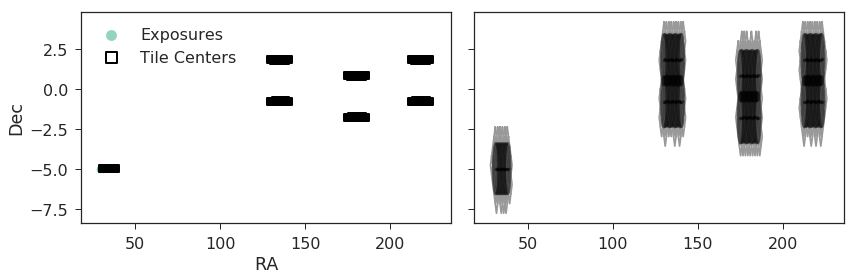

In [28]:
pixels = qa_tiles2pixels(tiles, nside=nside_mock_targets, overwrite=overwrite_tiles)
pixels

* separate these plots into four different fields
* plot up histograms of seeing, sky conditions, exposure time, etc.

## Simulate noiseless spectra using select_mock_targets.

Then, merge the target, sky, and stdstar catalogs and build the Merged Target List (MTL) file.

In [29]:
def is_select_mock_targets_done(tilesfile, nside=64, verbose=True):
    """
    Check whether select_mock_targets successfully finished.
    """
    tiles  = Table(fitsio.read(tilesfile, ext=1))
    pixels = tiles2pixels(tiles, nside=nside)
    
    done = True

    for filetype in ['target', 'truth', 'sky', 'standards-dark', 'standards-bright']:
        filenames = glob.glob(os.path.join(targetdir, '*', '*', '{}*.fits'.format(filetype)))
    
        if verbose:
            print('{}/{} {} files'.format(len(filenames), len(pixels), filetype))
        
        if len(filenames) != len(pixels):
            done = False

    return done

In [30]:
def select_mock_targets(tilesfile, nside=64, overwrite=False, verbose=False, mpi=True, no_spectra=False):
    """
    Run select_mock_targets.
    
    For debugging in an interactive node:
    
    mpi_select_mock_targets --output_dir /global/cscratch1/sd/ioannis/svdc-summer2018/targets \
       --config /global/cscratch1/sd/ioannis/repos/survey-validation/svdc-summer2018/mock-targets.yaml \
       --seed 123 --nproc 16 --nside 64 --healpixels 21883
    
    INFO:mpi_select_mock_targets:173:<module>: Pixels [21883] took 16.6 minutes
    """
    logfilename = os.path.join(targetdir, 'select_mock_targets.log')
    
    # or not is_select_mock_targets_done(tilesfile, nside=nside, verbose=verbose)
    if overwrite:
        print('Starting select_mock_targets at {}'.format(time.asctime()))
        print('Logging to {}'.format(logfilename))

        configfile = os.path.join(codedir, 'mock-targets.yaml')

        if mpi:
            cmd  = "srun -A desi -N 15 -n 30 -c 16 -C haswell -t 00:60:00 --qos interactive"
            cmd += " mpi_select_mock_targets --output_dir {targetdir} --config {configfile}"
            cmd += " --seed {seed} --nproc 16 --nside {nside} --tiles {tilesfile} "
        
        else:
            cmd  = "select_mock_targets --output_dir {targetdir} --config {configfile}"
            cmd += " --seed {seed} --nproc 4 --nside {nside} --tiles {tilesfile} --overwrite "
        
        if no_spectra:
            cmd += "--no-spectra"
        
        cmd = cmd.format(targetdir=targetdir, tilesfile=tilesfile, 
                         configfile=configfile, seed=seed, nside=nside)
        
        print(cmd)
    
        with open(logfilename, 'w') as logfile:
            err = subprocess.call(cmd.split(), stderr=logfile, stdout=logfile)
            
            if err != 0:
                print('select_mock_targets failed err={}; see {}'.format(err, logfilename))
                
            else:
                print('done at {}'.format(time.asctime()))
                
    else:
        print('All done with select_mock_targets; see log file {}'.format(logfilename))            

In [31]:
def join_targets_truth_mtl(overwrite=False):
    mtlfile     = os.path.join(targetdir, 'mtl.fits')
    truthfile   = os.path.join(targetdir, 'truth.fits')
    targetsfile = os.path.join(targetdir, 'targets.fits')

    if (overwrite or not os.path.isfile(mtlfile) or not os.path.isfile(targetsfile) or not os.path.isfile(truthfile)):        
        cmd = "join_mock_targets --mockdir {} --overwrite".format(targetdir)
        
        print(cmd)
        
        err = subprocess.call(cmd.split())
        
        if err != 0:
            print('join_mock_targets failed err={}'.format(err))
        
        else:
            print('Successfully joined all targets and truth catalogs.')
        
    else:
        print('Using existing truth.fits {}'.format(truthfile))        
        print('Using existing targets.fits file {}'.format(targetsfile))        
        print('Using existing merged target list {}'.format(mtlfile))        

In [32]:
select_mock_targets(tilesfile, nside=nside_mock_targets, verbose=True, mpi=True,
                    overwrite=overwrite_mock_spectra, no_spectra=True)

All done with select_mock_targets; see log file /global/cscratch1/sd/mjwilson/svdc-summer2018/targets/select_mock_targets.log


In [37]:
join_targets_truth_mtl(overwrite=overwrite_join_spectra)

join_mock_targets --mockdir /global/cscratch1/sd/mjwilson/svdc-summer2018/targets --force
Successfully joined all targets and truth catalogs.


In [50]:
#### [ToDo] Targeting QA.

#### Rewrite NUMOBS_MORE in .mtl: 4 observations per target in SV. 

In [47]:
def rewire_mtl():
  mtl = fits.open(basedir + '/targets/mtl.fits')
  mtl[1].data['NUMOBS_MORE'][mtl[1].data['NUMOBS_MORE'] > 0] = 4
  mtl.writeto(basedir + '/targets/mtl.fits', overwrite=True)

In [48]:
rewire_mtl()

## Fiber assignment

In [38]:
def is_fiberassign_done(tilesfile, verbose=False):
    """
    Check whether fiberassign successfully finished.
    """
    
    tiles = Table(fitsio.read(tilesfile, ext=1))
    done  = True
    
    for tileid in tiles['TILEID']:
        tilefile = os.path.join(fibassigndir, 'tile_{:05d}.fits'.format(tileid))
        
        if not os.path.exists(tilefile):
            done = False
            
            if verbose:
                print('Missing {}'.format(tilefile))

    return done

In [57]:
def run_fiberassign(tilesfile, overwrite=False, verbose=False):
    '''
    To debug:  
    
    fiberassign  --mtl /global/cscratch1/sd/mjwilson/svdc-summer2018/targets/mtl.fits 
                 --stdstar /global/cscratch1/sd/mjwilson/svdc-summer2018/targets/standards-dark.fits 
                 --sky /global/cscratch1/sd/mjwilson/svdc-summer2018/targets/sky.fits 
                 --surveytiles $HOME/desi/survey-validation/svdc-summer2018/bgs-gama-tiles-kdawson_100000.txt 
                 --footprint $HOME/desi/survey-validation/svdc-summer2018/bgs-gama-tiles-kdawson.fits 
                 --fibstatusfile /global/homes/m/mjwilson/desi/survey-validation/svdc-summer2018/fiberstatus.ecsv 
                 --outdir /global/cscratch1/sd/mjwilson/svdc-summer2018/fiberassign
                 --nstarpetal 20
                 --nskypetal 80
                 --overwrite
    '''
    
    logfilename = os.path.join(fibassigndir, 'fiberassign.log')

    if overwrite or not is_fiberassign_done(tilesfile, verbose=verbose):
        print('Generating lists of dark and bright tiles')

        tiles = Table(fitsio.read(tilesfile, ext=1))

        bx, dx = None, None

        for tileid, program  in zip(tiles['TILEID'], tiles['PROGRAM']):
            if program == 'BRIGHT':
                if bx is None:
                    bx = open(os.path.join(fibassigndir, 'bright-tiles.txt'), 'w')
                bx.write(str(tileid)+'\n')
                
            else:
                if dx is None:
                    dx = open(os.path.join(fibassigndir, 'dark-tiles.txt'), 'w')
                dx.write(str(tileid)+'\n')
                
        if bx:
            bx.close()
        
        if dx:
            dx.close()

        # Remove any leftover tile files
        for tilefile in glob.glob(fibassigndir + '/tile_*.fits'):
            os.remove(tilefile)

        cmd   = "fiberassign "
        cmd  += " --mtl {}/mtl.fits".format(targetdir)
        cmd  += " --stdstar {}/{{stdfile}}".format(targetdir)
        cmd  += " --sky {}/sky.fits".format(targetdir)
        cmd  += " --surveytiles {}/{{surveytiles}}".format(fibassigndir)
        cmd  += " --footprint {tilesfile}"
        #cmd += " --positioners {}/data/focalplane/fiberpos.fits".format(os.getenv('DESIMODEL'))
        cmd  += " --fibstatusfile {}/fiberstatus.ecsv".format(codedir)
        cmd  += " --outdir {}".format(fibassigndir)

        # Run fiberassign
        print('Logging to {}'.format(logfilename)); print()
        
        with open(logfilename, 'w') as logfile:
            for program in ['dark', 'bright']:
                stdfile     = 'standards-{}.fits'.format(program)
                surveytiles =      '{}-tiles.txt'.format(program)
        
                if os.path.isfile(os.path.join(fibassigndir, surveytiles)):
                    cmdx = cmd.format(stdfile=stdfile, surveytiles=surveytiles,
                                      tilesfile=tilesfile)
                    print(cmdx)
                
                    err = subprocess.call(cmdx.split(), stdout=logfile, stderr=logfile)

                    if err != 0:
                        print('fiberassign failed err={}; see {}'.format(err, logfilename))
        
        if is_fiberassign_done(tilesfile, verbose=True):
            print('Success; Running QA.')
            print()

            !qa-fiberassign $fibassigndir/tile*.fits --targets $targetdir/targets.fits
        
        else:
            print('ERROR: missing fiberassign output files')
        
    else:
        print('Finished fiber assignment; see log file {}'.format(logfilename))            

In [60]:
#  Successfully run in shell. 
%time run_fiberassign(os.path.join(codedir, 'bgs-gama-tiles_%s.fits' % 'G02'), overwrite=overwrite_fiberassign)

Generating lists of dark and bright tiles
Logging to /global/cscratch1/sd/mjwilson/svdc-summer2018/fiberassign/fiberassign.log

fiberassign  --mtl /global/cscratch1/sd/mjwilson/svdc-summer2018/targets/mtl.fits --stdstar /global/cscratch1/sd/mjwilson/svdc-summer2018/targets/standards-dark.fits --sky /global/cscratch1/sd/mjwilson/svdc-summer2018/targets/sky.fits --surveytiles /global/cscratch1/sd/mjwilson/svdc-summer2018/fiberassign/dark-tiles.txt --footprint /global/homes/m/mjwilson/desi/survey-validation/svdc-summer2018/bgs-gama-tiles_G02.fits --fibstatusfile /global/homes/m/mjwilson/desi/survey-validation/svdc-summer2018/fiberstatus.ecsv --outdir /global/cscratch1/sd/mjwilson/svdc-summer2018/fiberassign
fiberassign failed err=1; see /global/cscratch1/sd/mjwilson/svdc-summer2018/fiberassign/fiberassign.log
Missing /global/cscratch1/sd/mjwilson/svdc-summer2018/fiberassign/tile_100084.fits
Missing /global/cscratch1/sd/mjwilson/svdc-summer2018/fiberassign/tile_100085.fits
Missing /global/

### Combine surveysim, mocks, and fiberassign into simspec files.

[This step took roughly 27 minutes on my laptop with two tiles.]

In [ ]:
def is_newexp_done(explist, verbose=False):    
    numnights = len(set(explist['NIGHT']))
    nexp = len(explist)  #- 3 arc/night + 3 flat/night + science
    simspecfiles = glob.glob(simdatadir+'/*/simspec*.fits')
    fibermapfiles = glob.glob(simdatadir+'/*/fibermap*.fits')
    if verbose:
        print('{}/{} simspec files'.format(len(simspecfiles), nexp))
        print('{}/{} fibermap files'.format(len(fibermapfiles), nexp))

    if len(simspecfiles) != nexp:
        return False
    elif len(fibermapfiles) != nexp:
        return False
    else:
        return True

In [ ]:
def run_newexp(tilefile, explist, overwrite=False):
    """
    Run newexp.
    """
    
    logfilename = os.path.join(simdatadir, 'newexp.log')
    
    if overwrite or not is_newexp_done(explist):
        logfilename = os.path.join(simdatadir, 'newexp.log')
        print('Logging to {}'.format(logfilename))

        cmd = " wrap-newexp --fiberassign {}".format(fibassigndir)
        cmd += " --mockdir {}".format(targetdir)
        cmd += " --obslist {}/exposures.fits".format(surveydir)
        cmd += " --tilefile {}".format(tilefile)
        #cmd += " --dryrun"
        if overwrite:
            cmd += " --force"
        
        print('Starting at {}'.format(time.asctime()))
        
        if 'NERSC_HOST' in os.environ:
            nodes = 15
            nersc_cmd = "srun -A desi -N {nodes} -n {nodes} -c 32".format(nodes=nodes)
            nersc_cmd += " -C haswell -t 00:15:00 --qos interactive"
            cmd = nersc_cmd+cmd
        
        print(cmd)

        with open(logfilename, 'w') as logfile:
            err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
            if err != 0:
                print('ERROR {} running wrap-newexp; see {}'.format(err, logfilename))
            else:
                print('done')            
    else:
        print('newexp is done')
        
        is_newexp_done(explist, verbose=True)

In [ ]:
%time run_newexp(G02tilesfile, explist, overwrite=overwrite_simspec)

### Generate noisy uncalibrated spectra  using fastframe.

In [ ]:
def is_fastframe_done(explist, reduxdir, verbose=False):
    nflat = np.count_nonzero(explist['FLAVOR'] == 'flat')
    nscience = np.count_nonzero(explist['FLAVOR'] == 'science')
    nframe = 30*(nflat + nscience)
    framefiles = glob.glob(reduxdir+'/exposures/*/*/frame*.fits')
    if verbose:
        print('{}/{} frame files'.format(len(framefiles), nframe))
    
    if len(framefiles) != nframe:
        return False
    else:
        return True

In [ ]:
def run_fastframe(overwrite=False):
    if is_fastframe_done(explist, reduxdir, verbose=True):
        print('fastframe already done; skipping')
    else:
        logfilename = os.path.join(reduxdir, 'exposures', 'fastframe.log')
        os.makedirs(os.path.dirname(logfilename), exist_ok=True)
        print('Running fastframe batch job; should take ~7 min')
        print('Starting at {}'.format(time.asctime()))
        print('Logging to {}'.format(logfilename))
        
        nodes = 15

        cmd = "srun -A desi -N {nodes} -n {nodes} -c 32 -C haswell -t 00:20:00 --qos interactive".format(nodes=nodes)
        cmd += " wrap-fastframe --mpi"
        with open(logfilename, 'w') as logfile:
            err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
            if err != 0:
                print('ERROR {} running wrap-fastframe; see {}'.format(err, logfilename))
            else:
                print('done at {}'.format(time.asctime()))

        if is_fastframe_done(explist, reduxdir, verbose=True):
            print('SUCCESS')
        else:
            print('ERROR; see {}'.format(logfilename))